In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import torch
import torchvision.transforms as transforms
import torchsummary

from torchvision.datasets import CIFAR100, CIFAR10
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import DataLoader, TensorDataset

from medmnist import PathMNIST, ChestMNIST, DermaMNIST, OCTMNIST, PneumoniaMNIST, RetinaMNIST, BreastMNIST
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

warnings.filterwarnings("ignore")

In [2]:
# Configurations

dataset = 'pathmnist'
img_size = 28
batch_size = 64
num_classes = 9
finetuning_epochs = 15
epochs = 100

### Note

All Datasets will be of the format (N, C, H, W) with values between 0 and 1, unless stated otherwise.

This format is easier to deal with in PyTorch.

In [3]:
srmodel = torch.load('model/model_srresnet.pth')["model"]
srmodel = srmodel.cuda()

In [4]:
torchsummary.summary(srmodel, (3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]          15,552
         LeakyReLU-2           [-1, 64, 28, 28]               0
            Conv2d-3           [-1, 64, 28, 28]          36,864
    InstanceNorm2d-4           [-1, 64, 28, 28]             128
         LeakyReLU-5           [-1, 64, 28, 28]               0
            Conv2d-6           [-1, 64, 28, 28]          36,864
    InstanceNorm2d-7           [-1, 64, 28, 28]             128
   _Residual_Block-8           [-1, 64, 28, 28]               0
            Conv2d-9           [-1, 64, 28, 28]          36,864
   InstanceNorm2d-10           [-1, 64, 28, 28]             128
        LeakyReLU-11           [-1, 64, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          36,864
   InstanceNorm2d-13           [-1, 64, 28, 28]             128
  _Residual_Block-14           [-1, 64,

In [5]:
def generate_sr_dataset(dataset, model):
    model.cuda()
    sr_images, sr_targets = [], []    
    dataloader = DataLoader(dataset, batch_size=512, shuffle=False, num_workers=4)
    for (inputs, targets) in tqdm(dataloader):
        with torch.no_grad():
            inputs = inputs.cuda()
            inputs = Variable(inputs).float()
            sr_inputs = model(inputs)
            inputs.cpu()
            sr_images.append(sr_inputs.cpu().numpy().astype(np.float32))
            sr_targets.append(targets.numpy().astype(np.int64))
    model.cpu()
    sr_images = np.concatenate(sr_images, axis=0).clip(0, 1)
    sr_targets = np.concatenate(sr_targets, axis=0)

    sr_images = torch.from_numpy(sr_images)
    sr_targets = torch.from_numpy(sr_targets)
    sr_dataset = TensorDataset(sr_images, sr_targets)
    return sr_dataset

In [6]:
def get_dataset(dataset, transform):
    if dataset == 'pathmnist':
        train_dataset = PathMNIST(root='data', split='train', transform=transform, download=True)
        val_dataset = PathMNIST(root='data', split='val', transform=transform, download=True)
        test_dataset = PathMNIST(root='data', split='test', transform=transform, download=True)
    elif dataset == 'chestmnist':
        train_dataset = ChestMNIST(root='data', split='train', transform=transform, download=True)
        val_dataset = ChestMNIST(root='data', split='val', transform=transform, download=True)
        test_dataset = ChestMNIST(root='data', split='test', transform=transform, download=True)
    elif dataset == 'dermamnist':
        train_dataset = DermaMNIST(root='data', split='train', transform=transform, download=True)
        val_dataset = DermaMNIST(root='data', split='val', transform=transform, download=True)
        test_dataset = DermaMNIST(root='data', split='test', transform=transform, download=True)
    elif dataset == 'octmnist':
        train_dataset = OCTMNIST(root='data', split='train', transform=transform, download=True)
        val_dataset = OCTMNIST(root='data', split='val', transform=transform, download=True)
        test_dataset = OCTMNIST(root='data', split='test', transform=transform, download=True)
    elif dataset == 'pneumoniamnist':
        train_dataset = PneumoniaMNIST(root='data', split='train', transform=transform, download=True)
        val_dataset = PneumoniaMNIST(root='data', split='val', transform=transform, download=True)
        test_dataset = PneumoniaMNIST(root='data', split='test', transform=transform, download=True)
    elif dataset == 'retinamnist':
        train_dataset = RetinaMNIST(root='data', split='train', transform=transform, download=True)
        val_dataset = RetinaMNIST(root='data', split='val', transform=transform, download=True)
        test_dataset = RetinaMNIST(root='data', split='test', transform=transform, download=True)
    elif dataset == 'breastmnist':
        train_dataset = BreastMNIST(root='data', split='train', transform=transform, download=True)
        val_dataset = BreastMNIST(root='data', split='val', transform=transform, download=True)
        test_dataset = BreastMNIST(root='data', split='test', transform=transform, download=True)
    else:
        raise ValueError('Wrong dataset name!')
    return train_dataset, val_dataset, test_dataset

In [7]:
# trainset = CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
# testset = CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

lr_trainset, lr_valset, lr_testset = get_dataset(dataset, transforms.ToTensor())

sr_trainset = generate_sr_dataset(lr_trainset, srmodel)
sr_valset = generate_sr_dataset(lr_valset, srmodel)
sr_testset = generate_sr_dataset(lr_testset, srmodel)

Using downloaded and verified file: data/pathmnist.npz
Using downloaded and verified file: data/pathmnist.npz
Using downloaded and verified file: data/pathmnist.npz


  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [8]:
bc_transform = transforms.Compose([
    transforms.Resize((4*img_size, 4*img_size), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor()
])

bc_trainset, bc_valset, bc_testset = get_dataset(dataset, bc_transform)

Using downloaded and verified file: data/pathmnist.npz
Using downloaded and verified file: data/pathmnist.npz
Using downloaded and verified file: data/pathmnist.npz


In [9]:
lr_trainloader = DataLoader(lr_trainset, batch_size=batch_size, shuffle=False, num_workers=4)
lr_valloader = DataLoader(lr_valset, batch_size=batch_size, shuffle=False, num_workers=4)
lr_testloader = DataLoader(lr_testset, batch_size=batch_size, shuffle=False, num_workers=4)

sr_trainloader = DataLoader(sr_trainset, batch_size=batch_size, shuffle=False, num_workers=4)
sr_valloader = DataLoader(sr_valset, batch_size=batch_size, shuffle=False, num_workers=4)
sr_testloader = DataLoader(sr_testset, batch_size=batch_size, shuffle=False, num_workers=4)

bc_trainloader = DataLoader(bc_trainset, batch_size=batch_size, shuffle=False, num_workers=4)
bc_valloader = DataLoader(bc_valset, batch_size=batch_size, shuffle=False, num_workers=4)
bc_testloader = DataLoader(bc_testset, batch_size=batch_size, shuffle=False, num_workers=4)

torch.Size([64, 3, 28, 28]) torch.Size([64, 1])


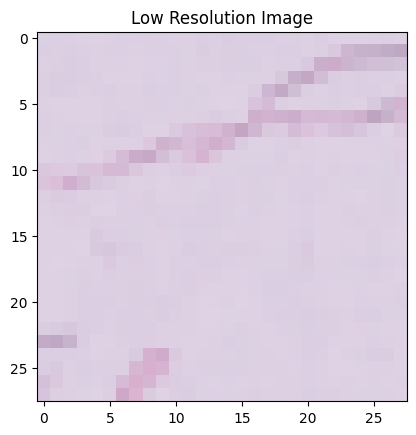

In [10]:
for i, (inputs, targets) in enumerate(lr_trainloader):
    print(inputs.shape, targets.shape)
    plt.imshow(inputs[0].permute(1, 2, 0))
    plt.title('Low Resolution Image')
    plt.show()
    break

torch.Size([64, 3, 112, 112]) torch.Size([64, 1])


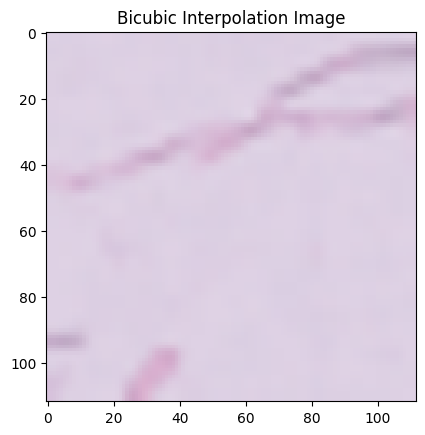

In [11]:
for i, (inputs, targets) in enumerate(bc_trainloader):
    print(inputs.shape, targets.shape)
    plt.imshow(inputs[0].permute(1, 2, 0))
    plt.title('Bicubic Interpolation Image')
    plt.show()
    break

torch.Size([64, 3, 112, 112]) torch.Size([64, 1])


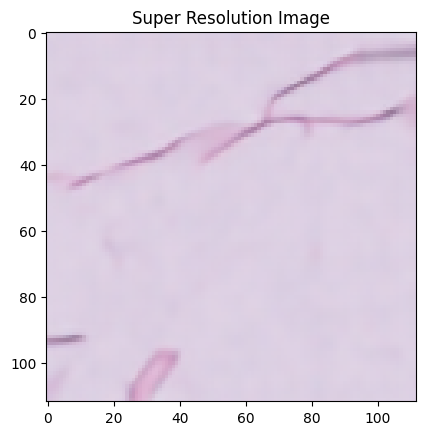

In [12]:
for i, (inputs, targets) in enumerate(sr_trainloader):
    print(inputs.shape, targets.shape)
    plt.imshow(inputs[0].permute(1, 2, 0))
    plt.title('Super Resolution Image')
    plt.show()
    break

### Training a CNN

In [13]:
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
# torch summary
import torchsummary

In [14]:
def create_model(pretrain=True, out_channels=10):
    model = models.resnet18(pretrained=pretrain)
    model.fc = torch.nn.Linear(512, out_channels)
    model = model.cuda()
    return model

def train(model, trainloader, valloader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    accuracy = []
    for epoch in tqdm(range(epochs)):
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(trainloader):
            inputs = inputs.cuda()
            targets = targets.squeeze().cuda()
            inputs = Variable(inputs).float()
            targets = Variable(targets).long()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        correct = 0
        total = 0
        with torch.no_grad():
            for (inputs, targets) in valloader:
                inputs = inputs.cuda()
                targets = targets.squeeze().cuda()
                inputs = Variable(inputs).float()
                targets = Variable(targets).long()
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        print(f'Accuracy of the network on the val images: {(100 * correct / total):.2f} %')
        print('Loss on train set: ', running_loss / len(trainloader))
        accuracy.append(correct / total)
    return accuracy

def test(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for (inputs, targets) in testloader:
            inputs = inputs.cuda()
            targets = targets.squeeze().cuda()
            inputs = Variable(inputs).float()
            targets = Variable(targets).long()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    print(f'Accuracy of the network on the test images: {(100 * correct / total):.2f} %')

In [15]:

def get_predictions(model, testloader):
    preds = []
    with torch.no_grad():
        for (inputs, targets) in tqdm(testloader):
            inputs = inputs.cuda()
            targets = targets.squeeze().cuda()
            inputs = Variable(inputs).float()
            targets = Variable(targets).long()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            preds.append(predicted.cpu().numpy())
    preds = np.concatenate(preds, axis=0)
    return preds


### Models finetuned on our datasets

In [16]:
model = create_model(True, num_classes)
model.load_state_dict(torch.load(f'model/model_lr_finetune15_{dataset}.pth'))
test(model, lr_testloader)

Accuracy of the network on the test images: 80.85 %


In [17]:
model = create_model(True, num_classes)
model.load_state_dict(torch.load(f'model/model_bc_finetune15_{dataset}.pth'))
test(model, bc_testloader)

Accuracy of the network on the test images: 88.80 %


In [18]:
model = create_model(True, num_classes)
model.load_state_dict(torch.load(f'model/model_sr_finetune15_{dataset}.pth'))
test(model, sr_testloader)

Accuracy of the network on the test images: 90.17 %


In [19]:

model = create_model(True, num_classes)
model.load_state_dict(torch.load(f'model/model_sr_finetune15_{dataset}.pth'))
model.cuda()
sr_preds = get_predictions(model, sr_testloader)
model.cpu()

model = create_model(True, num_classes)
model.load_state_dict(torch.load(f'model/model_bc_finetune15_{dataset}.pth'))
model.cuda()
bc_preds = get_predictions(model, bc_testloader)
model.cpu()

model = create_model(True, num_classes)
model.load_state_dict(torch.load(f'model/model_lr_finetune15_{dataset}.pth'))
model.cuda()
lr_preds = get_predictions(model, lr_testloader)
model.cpu()

labels = []
for (inputs, targets) in tqdm(lr_testloader):
    labels.append(targets.numpy())
labels = np.concatenate(labels, axis=0)
labels = labels.squeeze()

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

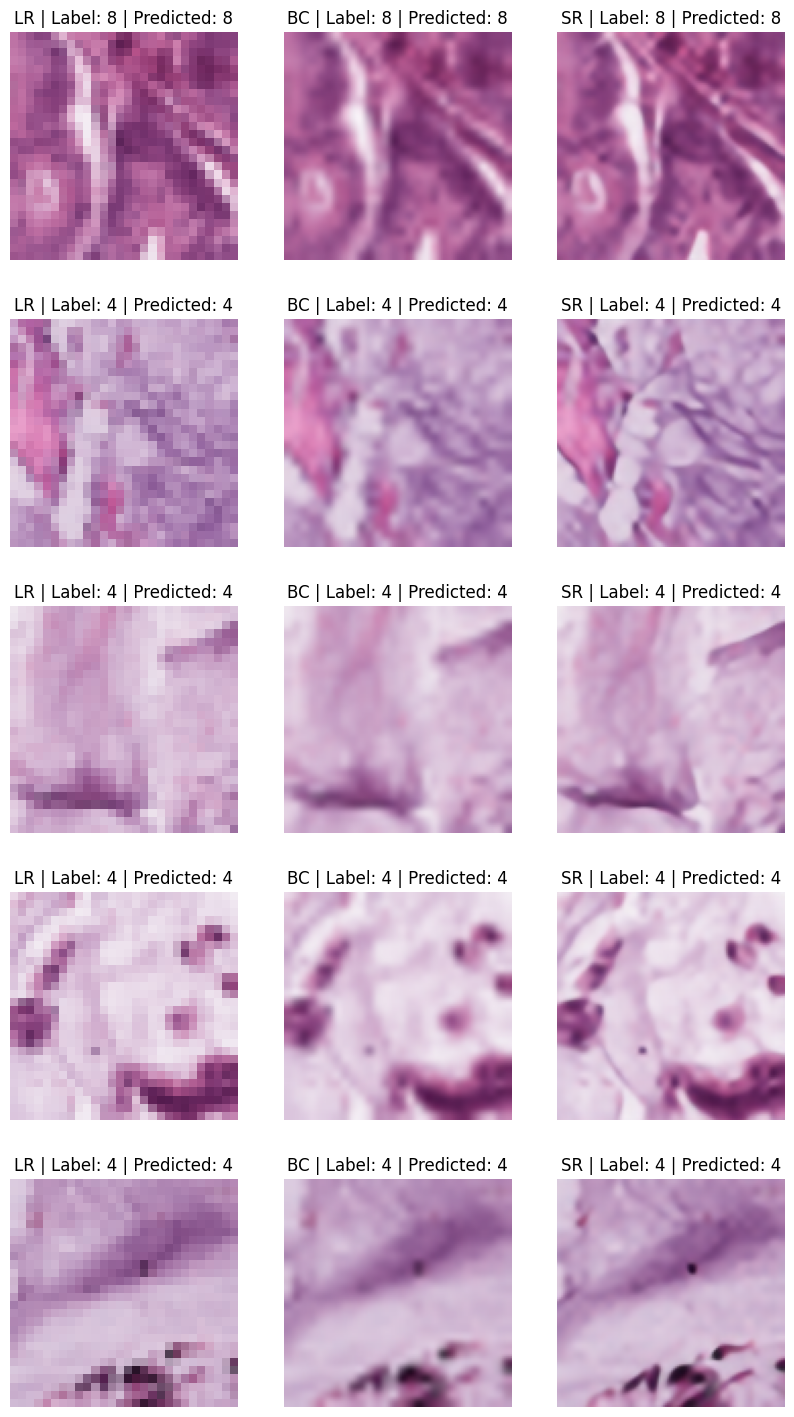

In [20]:
correct = np.where((sr_preds == labels) & (sr_preds == lr_preds) & (sr_preds == bc_preds))[0]
plt.figure(figsize=(10, 18))
for i in range(5):
    plt.subplot(5, 3, 3*i+1)
    plt.imshow(lr_testset[correct[i]][0].permute(1, 2, 0))
    plt.title(f'LR | Label: {labels[correct[i]]} | Predicted: {lr_preds[correct[i]]}')
    plt.axis('off')
    plt.subplot(5, 3, 3*i+2)
    plt.imshow(bc_testset[correct[i]][0].permute(1, 2, 0))
    plt.title(f'BC | Label: {labels[correct[i]]} | Predicted: {bc_preds[correct[i]]}')
    plt.axis('off')
    plt.subplot(5, 3, 3*i+3)
    plt.imshow(sr_testset[correct[i]][0].permute(1, 2, 0))
    plt.title(f'SR | Label: {labels[correct[i]]} | Predicted: {sr_preds[correct[i]]}')
    plt.axis('off')
plt.show()

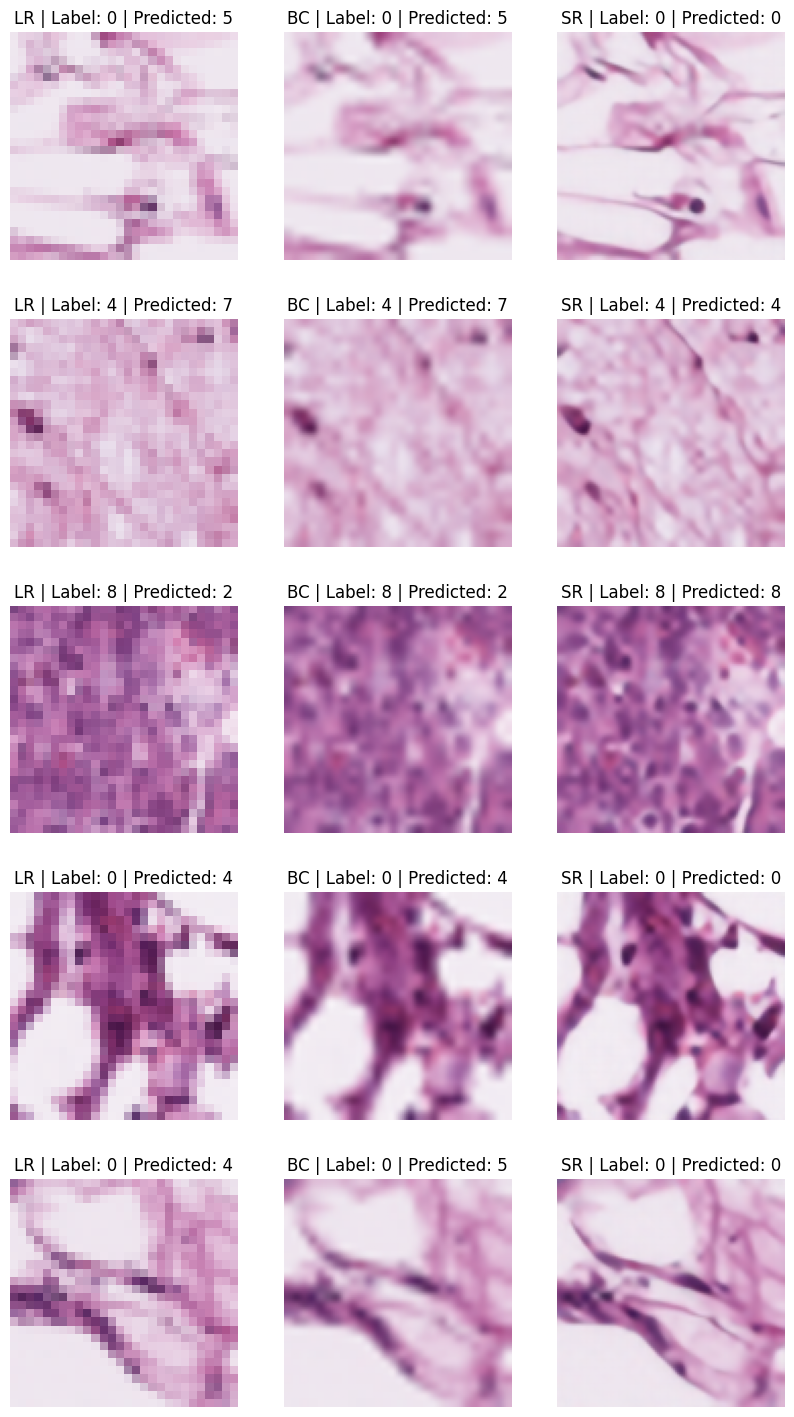

In [21]:
correct = np.where((sr_preds == labels) & (sr_preds != lr_preds) & (sr_preds != bc_preds))[0]
plt.figure(figsize=(10, 18))
for i in range(5):
    plt.subplot(5, 3, 3*i+1)
    plt.imshow(lr_testset[correct[i]][0].permute(1, 2, 0))
    plt.title(f'LR | Label: {labels[correct[i]]} | Predicted: {lr_preds[correct[i]]}')
    plt.axis('off')
    plt.subplot(5, 3, 3*i+2)
    plt.imshow(bc_testset[correct[i]][0].permute(1, 2, 0))
    plt.title(f'BC | Label: {labels[correct[i]]} | Predicted: {bc_preds[correct[i]]}')
    plt.axis('off')
    plt.subplot(5, 3, 3*i+3)
    plt.imshow(sr_testset[correct[i]][0].permute(1, 2, 0))
    plt.title(f'SR | Label: {labels[correct[i]]} | Predicted: {sr_preds[correct[i]]}')
    plt.axis('off')
plt.show()

In [23]:
print(np.sum((lr_preds == labels) & (bc_preds == labels) & (sr_preds == labels)))
print(np.sum((lr_preds != labels) & (bc_preds == labels) & (sr_preds == labels)))
print(np.sum((lr_preds == labels) & (bc_preds != labels) & (sr_preds == labels)))
print(np.sum((lr_preds == labels) & (bc_preds == labels) & (sr_preds != labels)))
print(np.sum((lr_preds != labels) & (bc_preds != labels) & (sr_preds == labels)))
print(np.sum((lr_preds == labels) & (bc_preds != labels) & (sr_preds != labels)))
print(np.sum((lr_preds != labels) & (bc_preds == labels) & (sr_preds != labels)))
print(np.sum((lr_preds != labels) & (bc_preds != labels) & (sr_preds != labels)))

5379
749
169
141
177
116
107
342


### Models trained from Scratch

In [21]:
model = create_model(False, num_classes)
model.load_state_dict(torch.load(f'model/model_lr_scratch100_{dataset}.pth'))
test(model, lr_testloader)

Accuracy of the network on the test images: 75.68 %


In [22]:
model = create_model(False, num_classes)
model.load_state_dict(torch.load(f'model/model_bc_scratch100_{dataset}.pth'))
test(model, bc_testloader)

Accuracy of the network on the test images: 81.75 %


In [23]:
model = create_model(False, num_classes)
model.load_state_dict(torch.load(f'model/model_sr_scratch100_{dataset}.pth'))
test(model, sr_testloader)

Accuracy of the network on the test images: 83.94 %


In [24]:

model = create_model(True, num_classes)
model.load_state_dict(torch.load(f'model/model_sr_finetune15_{dataset}.pth'))
model.cuda()
sr_preds = get_predictions(model, sr_testloader)
model.cpu()

model = create_model(True, num_classes)
model.load_state_dict(torch.load(f'model/model_bc_finetune15_{dataset}.pth'))
model.cuda()
bc_preds = get_predictions(model, bc_testloader)
model.cpu()

model = create_model(True, num_classes)
model.load_state_dict(torch.load(f'model/model_lr_finetune15_{dataset}.pth'))
model.cuda()
lr_preds = get_predictions(model, lr_testloader)
model.cpu()

labels = []
for (inputs, targets) in tqdm(lr_testloader):
    labels.append(targets.numpy())
labels = np.concatenate(labels, axis=0)
labels = labels.squeeze()

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

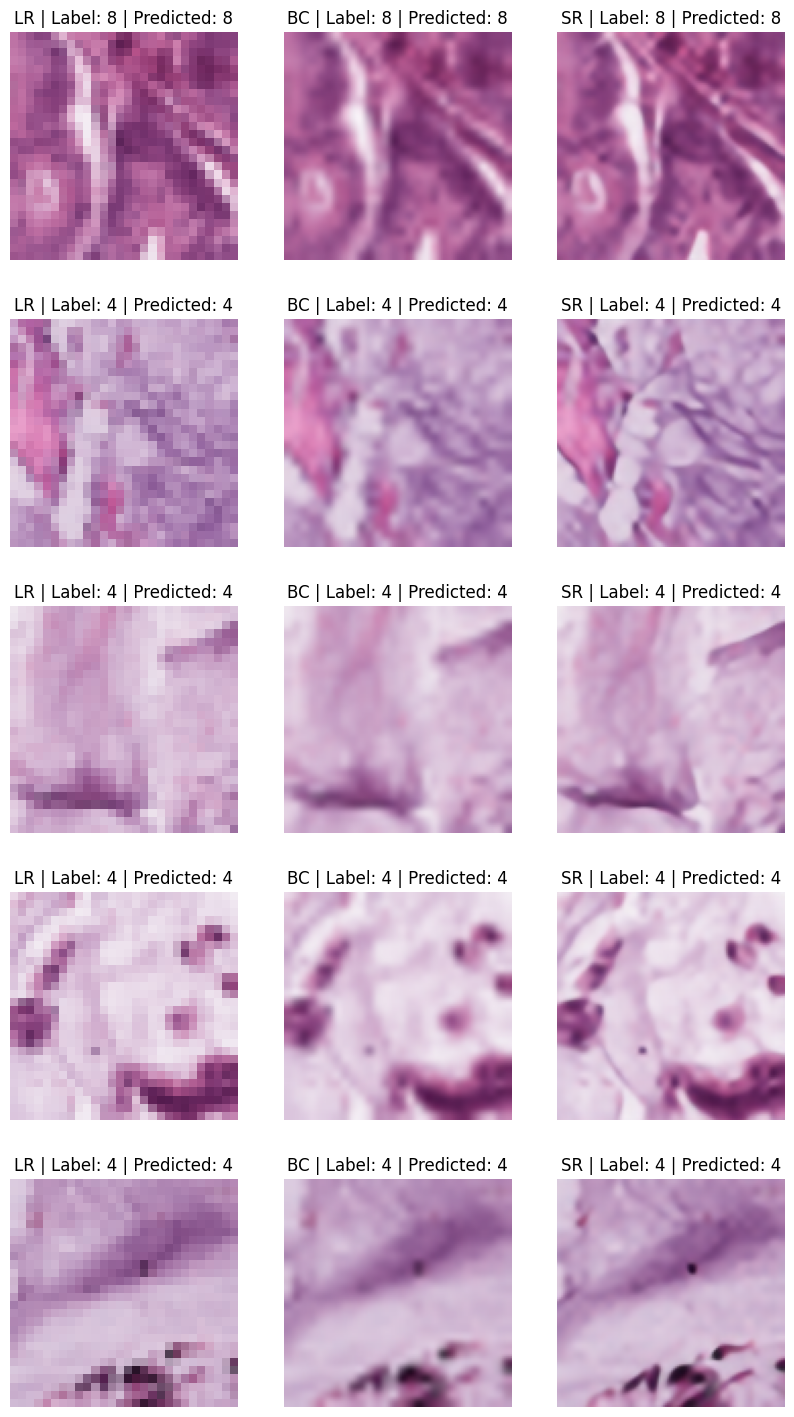

In [25]:
correct = np.where((sr_preds == labels) & (sr_preds == lr_preds) & (sr_preds == bc_preds))[0]
plt.figure(figsize=(10, 18))
for i in range(5):
    plt.subplot(5, 3, 3*i+1)
    plt.imshow(lr_testset[correct[i]][0].permute(1, 2, 0))
    plt.title(f'LR | Label: {labels[correct[i]]} | Predicted: {lr_preds[correct[i]]}')
    plt.axis('off')
    plt.subplot(5, 3, 3*i+2)
    plt.imshow(bc_testset[correct[i]][0].permute(1, 2, 0))
    plt.title(f'BC | Label: {labels[correct[i]]} | Predicted: {bc_preds[correct[i]]}')
    plt.axis('off')
    plt.subplot(5, 3, 3*i+3)
    plt.imshow(sr_testset[correct[i]][0].permute(1, 2, 0))
    plt.title(f'SR | Label: {labels[correct[i]]} | Predicted: {sr_preds[correct[i]]}')
    plt.axis('off')
plt.show()

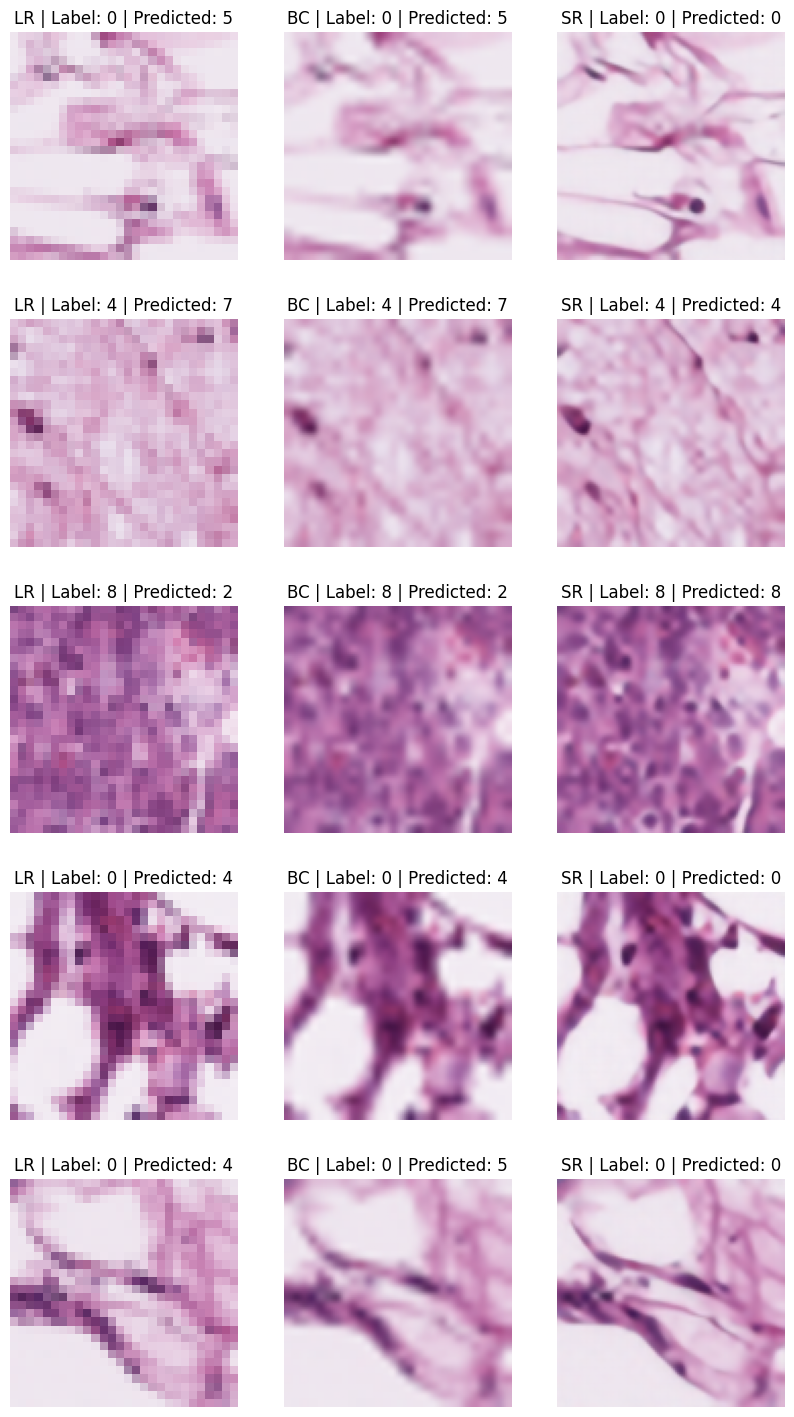

In [26]:
correct = np.where((sr_preds == labels) & (sr_preds != lr_preds) & (sr_preds != bc_preds))[0]
plt.figure(figsize=(10, 18))
for i in range(5):
    plt.subplot(5, 3, 3*i+1)
    plt.imshow(lr_testset[correct[i]][0].permute(1, 2, 0))
    plt.title(f'LR | Label: {labels[correct[i]]} | Predicted: {lr_preds[correct[i]]}')
    plt.axis('off')
    plt.subplot(5, 3, 3*i+2)
    plt.imshow(bc_testset[correct[i]][0].permute(1, 2, 0))
    plt.title(f'BC | Label: {labels[correct[i]]} | Predicted: {bc_preds[correct[i]]}')
    plt.axis('off')
    plt.subplot(5, 3, 3*i+3)
    plt.imshow(sr_testset[correct[i]][0].permute(1, 2, 0))
    plt.title(f'SR | Label: {labels[correct[i]]} | Predicted: {sr_preds[correct[i]]}')
    plt.axis('off')
plt.show()